# German Traffic Sign Benchmark - Hue Histograms

## Overview

### Description of the data
* The dataset is about the classification of images of German traffic signs into 43 distinct classes. The classes can be seen in the image below.
The classification is meant to be achieved by using only the global histogram of the hue values in HSV color space, resulting in 256 features per image.

<img src="https://i.imgur.com/AmCEexq.png" title="Traffic sign classes" alt="43 different traffic signs from germany" width="800px">

In [17]:
import math
import time

import joblib
import numpy as np
import matplotlib.pyplot as plt
import openml

from imblearn.pipeline import Pipeline as ILPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN

from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [4]:
openml.config.apikey = ''  # Insert key here 

In [5]:
RANDOM_STATE = 42

* Loading the data doesn't require any altering of the plain text files.

In [6]:
dataset = openml.datasets.get_dataset(41990)

X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array",
    target=dataset.default_target_attribute
    )

classes, class_counts = np.unique(y,return_counts=True)

# # Saving the dataset object structure
# import pprint
# with open('vars-dataset.txt', 'w', encoding='utf8') as f:
#     pprint.pprint(vars(dataset), stream=f)

In [7]:
# OpenML description

print(f'Dataset Name: {dataset.name}')
print(f'OpenML URL: {dataset.url}')
print(f'Original Data URL (link not working): {dataset.original_data_url}')
print(f'Paper URL: {dataset.paper_url}')

print('-'*60)
print(f'Description:\n{dataset.description}')
print('-'*60)

print(f'Licence {dataset.licence}')
print(f'Citation:\n{dataset.citation}')

Dataset Name: GTSRB-HueHist
OpenML URL: https://www.openml.org/data/v1/download/21389569/GTSRB-HueHist.arff
Original Data URL (link not working): http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
Paper URL: https://www.ini.rub.de/upload/file/1470692848_f03494010c16c36bab9e/StallkampEtAl_GTSRB_IJCNN2011.pdf
------------------------------------------------------------
Description:
The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. We cordially invite researchers from relevant fields to participate: The competition is designed to allow for participation without special domain knowledge.

# Pre-calculated features

To allow scientists without a background in image processing to participate, we several provide pre-calculated feature sets. Each feature set contains the same directory structure as the training image set. For details on the parameters of the feature al

* The sample size is 51839, with each sample comprising of 256 features (in essence they are 255 since the 256th is 1 - sum_of_the_rest).
The samples all probability distributions (all floats >= 0  and sum up to 1). There are no unordered features.  
* The headers are simply `pixel-00000, pixel-00001, ... , pixel-00255`. The rows don't have any special numbering.
* The class labels are in the `class` column and they are namely `0, 1, ... , 42`.
* There are no missing values in the dataset.

In [8]:
print(f'Number of samples: {X.shape[0]}')
print(f'Number of features: {X.shape[1]}')
print(f'Headers: {attribute_names[0]} ... {attribute_names[-1]}')
print(f'Class field: {dataset.default_target_attribute}')
print(f'Classes: {classes[0]} ... {classes[-1]}')
print(f'Number of samples with missing values: {np.sum(np.any(np.isnan(X), axis=1))}')
print(f'Percentage of sample with missing values: {np.mean(np.any(np.isnan(X), axis=1)): .2%}')


Number of samples: 51839
Number of features: 256
Headers: pixel-00000 ... pixel-00255
Class field: class
Classes: 0 ... 42
Number of samples with missing values: 0
Percentage of sample with missing values:  0.00%


In [9]:
# It is indeed a histogram
np.all(X >= 0) and np.all(np.isclose(np.sum(X, axis=1), 1))

True

* The dataset is not balanced, since we can see that there are classes which are more than 1.5 times more frequent than some other class (11 times in our worst case).

In [10]:
rarest = np.argmin(class_counts)
most_common = np.argmax(class_counts)

print('The rarest class is {} with frequency {}.'.format(
    classes[rarest], class_counts[rarest]))
print('The most common class is {} with frequency {}.'.format(
    classes[most_common], class_counts[most_common]))
print('The most common class appears {:.1f} times more often than the rarest one.'.format(
    class_counts[most_common] / class_counts[rarest]))

The rarest class is 0 with frequency 270.
The most common class is 2 with frequency 3000.
The most common class appears 11.1 times more often than the rarest one.


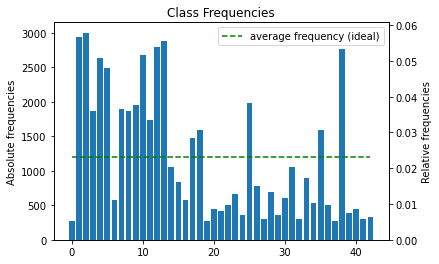

In [11]:
plt.bar(classes, class_counts)
plt.ylabel('Absolute frequencies')
plt.twinx()
plt.bar(classes, class_counts / y.shape[0])
plt.plot((classes[0], classes[-1]),
         (1/len(classes), 1/len(classes)),
        'g--',
        label='average frequency (ideal)')
plt.legend()
plt.ylabel('Relative frequencies')
plt.title('Class Frequencies')
plt.show()

## Preparation

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, shuffle=True,
    random_state=RANDOM_STATE
)

## Classification

### Out of the box

We can see that the results are quite poor, with the exception of the K Nearest Neighbours classifier, which had a remarkably good accuracy score (and f1 score) of 73%. Those unsatisfying results are to be expected since we haven't tweaked any of the hyperparameters yet. In addition to that, the classes are very imbalanced. We also need to keep in mind that it's usually harder to correctly classify data in 43 different classes instead of, say, 2. For example if a traffic sign has 5 others that look very similar to it, then it's expected to have our sign misclassified as one of those 5.

It is also worth noting that the F1 score of the Dummy classifier is very low. This is because it predicts everything into a single class (the most frequent one: class 2), since the default strategy is `strategy='prior'`.

In [13]:
clf_classes = [
    DummyClassifier,
    GaussianNB,
    KNeighborsClassifier,
    LogisticRegression,
    MLPClassifier,
    SVC
]

In [62]:
@ignore_warnings(category=ConvergenceWarning)
def get_default_measurement(clf_class, X_train, X_test, y_train, y_test):
    clf = clf_class()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    return acc, f1, clf

In [66]:
default_measurements = [get_default_measurement(clf_class, X_train, X_test, y_train, y_test) for clf_class in clf_classes]

In [14]:
# for acc, f1, clf in default_measurements:
#     print(f'| {type(clf).__name__} | {acc:.4f} | {f1: .4f} |')

**Accuracy and F1 score using the default values from sklearn**

|Classifier | Accuracy | F1 score|
| --- | --- | --- |
| DummyClassifier | 0.0592 |  0.0026 |
| GaussianNB | 0.1389 |  0.1168 |
| KNeighborsClassifier | 0.7307 |  0.7394 |
| LogisticRegression | 0.2059 |  0.0729 |
| MLPClassifier | 0.4064 |  0.3739 |
| SVC | 0.4584 |  0.4162 |

In [19]:
def plot_measurements(measurements, title, ax=None):

    accs, f1s, clfs = zip(*measurements)
    clf_names = [type(clf).__name__ for clf in clfs]
    xs = np.arange(len(measurements))
    width = 0.35

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))

    acc_bars = ax.bar(xs - width/2, accs, width, label='Accuracy')
    f1_bars = ax.bar(xs + width/2, f1s, width, label='F1')
    ax.bar_label(acc_bars, fmt='%.3f', padding=3)
    ax.bar_label(f1_bars, fmt='%.3f', padding=3)

    # plt.xlabel('Classifiers')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(xs, clf_names, rotation=30)
    ax.legend()

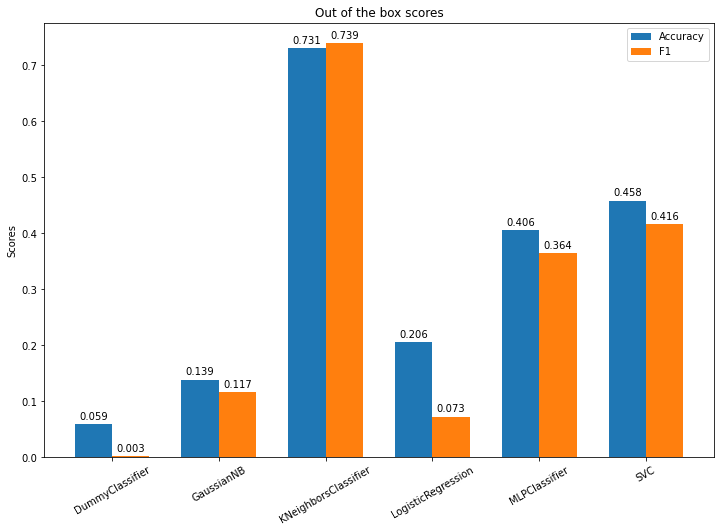

In [20]:
plot_measurements(default_measurements, title='Out of the box scores')
plt.show()

In [17]:
# The Dummy classifier predicts everything as the most frequent class.
np.all(default_measurements[0][2].predict(X_test) == classes[np.argmax(class_counts)])

True

In [18]:
# Confusion matrix for each classifier
def plot_confusion_matrices(measurements, suptitle=None, axs=None):

    # Compute the grid layout
    if axs is None:
        n = len(measurements)
        k = math.isqrt(n)
        q, r = divmod(n - k*k, k)
        nrows = k
        ncols = k + q + (r != 0)  # ceiling division
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    
    # Plot the confusion matrices
    for (_, _, clf), ax in zip(measurements, axs.flat):
        ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,
                                            colorbar=False, include_values=False, ax=ax)
        ax.set_title(type(clf).__name__)
        # ax.get_xaxis().set_visible(False)
        # ax.get_yaxis().set_visible(False)
        ax.axis('off')

    # Strip the axes of the unfilled parts of the grid (if there are any)
    for ax in axs.flat[n:]:
        ax.axis('off')

    if suptitle is not None:
        fig.suptitle(suptitle)
        
    fig.tight_layout()

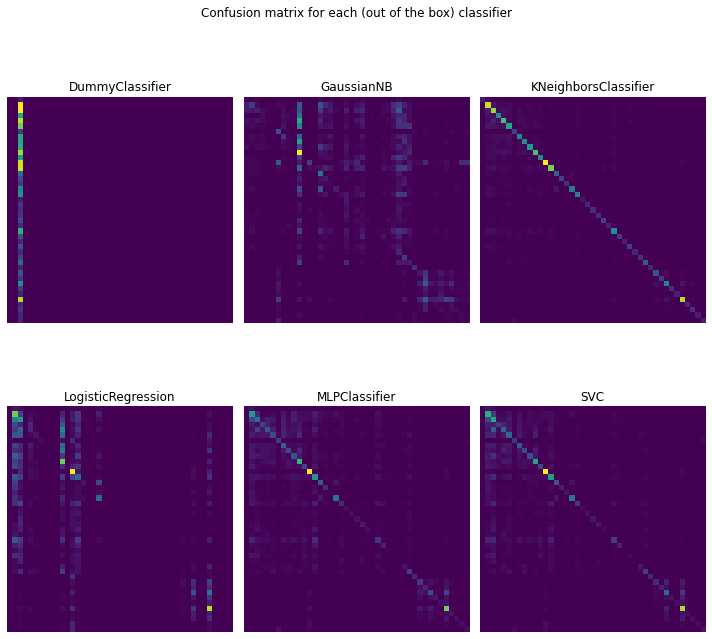

In [21]:
plot_confusion_matrices(default_measurements, suptitle='Confusion matrix for each (out of the box) classifier')
plt.show()

### Optimization

Since our data are probability distributions, applying any preprocessing like centering, scaling, or dimensionality reduction wouldn't make sense. We will use our feautures as they are.
Thus we will focus on balancing our dataset and searching for optimal hyperparameters of our models.

**Trying PCA**

As we can see, the variance is not distributed heavily into a few principal components - there is no clear cut-off point. For this reason we won't use PCA.

In [59]:
# There's no room for dimensionality reduction (except one, ).
pcapipe = ILPipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=None))
])
pcapipe.fit(X_train)
pca = pcapipe.named_steps['pca']
print(pca.explained_variance_ratio_[-1]) # Redundant variable, because the features sum up to one.
print()
print(*np.cumsum(pca.explained_variance_ratio_), sep=' ')

1.7699028e-14

0.14880534 0.21830462 0.2806598 0.32697922 0.36530456 0.39484277 0.42326277 0.4453382 0.4626757 0.47937262 0.49492753 0.5082819 0.5196726 0.5303996 0.5402014 0.5492458 0.5573983 0.565473 0.5726479 0.57938176 0.5858864 0.59220994 0.5980577 0.60342336 0.6086893 0.6137977 0.6186932 0.62342757 0.6279979 0.6324747 0.63674706 0.6409538 0.64491844 0.64881974 0.6525819 0.656303 0.6599543 0.6635883 0.6670678 0.67054176 0.6739911 0.6773973 0.68075204 0.68404746 0.6873308 0.6905968 0.6938256 0.6970074 0.7001673 0.70329016 0.706392 0.7094857 0.71254647 0.7155539 0.71851504 0.72147197 0.72438693 0.7272765 0.7301453 0.73299766 0.73582363 0.7386324 0.74139994 0.74416244 0.74691117 0.7496525 0.75235957 0.75505596 0.7577222 0.7603679 0.76300424 0.7656148 0.7682206 0.7707883 0.77333367 0.7758734 0.77838594 0.7808742 0.7833599 0.7858145 0.7882562 0.7906783 0.79308754 0.7954779 0.797828 0.8001686 0.80249333 0.80478734 0.807069 0.80931973 0.81153405 0.81372833 0.81590974 0.8180787 0.8202173 

## About Balancing the Data

Notice that our raw training set has 36287 samples. If we use undersampling, the sample drop to a mere 8084. If we use oversampling, then they skyrocket to 89282.

I tried gridsearch along with undersampling, with oversampling, as well as neither undersampling or oversampling. Undersampling (for 2*35 = 70 models) took roughly 17 minutes, no over/under-sampling ("equisampling") took about 3 hours, and oversampling has not finished yet (it has been running for 1.5 day on okeanos and it will be finished about 5 hours after the submission deadline).

The way I ran the experiments was to write a `train.py` file each time containing the appropriate instructions for training and saving the models and their logs. Specifically I ran the following command `python train.py 1>output/train-stdout.txt 2>output/train-stderr.txt &` while having the verbose setting of `GridSearchCV` set to `2`.


In [61]:
oversample = RandomOverSampler().fit_resample(X_train, y_train)
undersample = RandomUnderSampler().fit_resample(X_train, y_train)
midsample_Tomek = SMOTETomek().fit_resample(X_train, y_train)
midsample_ENN = SMOTEENN().fit_resample(X_train, y_train)

print(
    len(X_train),
    len(oversample[0]),
    len(undersample[0]),
    len(midsample_Tomek[0]),
    len(midsample_ENN[0]),
)

36287 89440 8084 89296 75618


### Undersampling (poor results)
Below we showcase the results of the grid search after undersampling.

In [21]:
pipes = {}
for clf_class in clf_classes[1:]:
    pipes[clf_class.__name__] = ILPipeline([
        ('balancer', RandomUnderSampler(random_state=RANDOM_STATE)),
        ('clf', clf_class()),
    ])

pipes

In [23]:
param_grids = {
    'GaussianNB': {
        'clf__priors': [
            # Uniform prior, same as `None` after balancing.
            np.full(len(classes), 1/len(classes)),
            # The prior before balancing.
            np.unique(y_train, return_counts=True)[1] / y_train.shape[0]
        ],
        # This is isn't really a hyperparameter. It's for numerical stability. 
        'clf__var_smoothing': [1e-09]  
    },
    'KNeighborsClassifier': {
        'clf__n_neighbors': [5, 20],
        'clf__weights': ['uniform', 'distance'],
        'clf__p': [1, 2],
        # 'clf__n_jobs': [-1]
    },
    'LogisticRegression': {
        'clf__penalty': ['l2'],
        'clf__C': [0.1, 1., 10.],
        'clf__max_iter': [100],
        # 'clf__n_jobs': [-1],
        'clf__random_state': [RANDOM_STATE]
    },
    'MLPClassifier': {
        'clf__hidden_layer_sizes': [(64,), (32, 64)],
        'clf__activation': ['logistic', 'relu'],
        'clf__alpha': [0.0001, 0.01],
        'clf__learning_rate_init': [0.001, 0.0001],
        'clf__batch_size': [256],
        'clf__max_iter': [200],
        'clf__random_state': [RANDOM_STATE]
    },
    'SVC': {
        'clf__C': [0.1, 1., 10.],
        'clf__kernel': ['linear', 'rbf'],
        'clf__max_iter': [200],
        'clf__random_state': [RANDOM_STATE]
    }
}

n_models = 2 * sum(1 for param_grid in param_grids.values()
                            for _ in ParameterGrid(param_grid))
print(f'{n_models} models will be cross validated')

70 models will be cross validated


In [20]:
def cv_train(scoring):
    cv_clfs = {}
    for name, pipe in pipes.items():
        estimator = GridSearchCV(
            pipe, param_grids[name], cv=10,
            scoring=scoring,
            error_score='raise',
            # verbose=2,
            n_jobs=-1
        )
        estimator.fit(X_train, y_train)
        cv_clfs[name] = estimator
    return cv_clfs

# cv_clfs_acc = cv_train(scoring='accuracy')
# cv_clfs_f1 = cv_train(scoring='f1_macro')

In [19]:
models_path_us = 'supervised-train-scripts/undersampling1/output/models.joblib'
cv_clfs_acc_us, cv_clfs_f1_us = joblib.load(models_path_us)

for name, clf in cv_clfs_acc_us.items():
    print(f'name={name}\nbest_score={clf.best_score_}\n')



name=GaussianNB
best_score=0.14137266470667048

name=KNeighborsClassifier
best_score=0.4792352840024755

name=LogisticRegression
best_score=0.15958893247249054

name=MLPClassifier
best_score=0.24942814118656434

name=SVC
best_score=0.4401848942565144



## "Equisampling" (much better results)
We will focus on this, since it gives the best results. The algorithm is the same as undersampling - we just need to comment out the undersampling part and use the normal sklearn `Pipeline` instead of the imblearn one.

In [55]:
models_path_es = 'supervised-train-scripts/equisampling/output/models.joblib'
cv_clfs_acc_es, cv_clfs_f1_es = joblib.load(models_path_es)

for name, clf in cv_clfs_acc_es.items():
    print(f'name={name}\nbest_score={clf.best_score_}\n')


name=GaussianNB
best_score=0.14239244199382467

name=KNeighborsClassifier
best_score=0.7908889343257473

name=LogisticRegression
best_score=0.2577782702917178

name=MLPClassifier
best_score=0.40474514986010945

name=SVC
best_score=0.5187256779045926



In [54]:
# Display the parameters of the best models for accuracy
for name, model in cv_clfs_acc_es.items():
    print(name)
    print(model.best_params_)
    print()

GaussianNB
{'clf__priors': array([0.00531871, 0.05591534, 0.0573208 , 0.03599085, 0.04999035,
       0.04864001, 0.01116102, 0.03673492, 0.03593573, 0.03761678,
       0.05178163, 0.03356574, 0.05329732, 0.05572244, 0.0201174 ,
       0.01719624, 0.01105079, 0.0284675 , 0.03056191, 0.0054565 ,
       0.00843277, 0.00812963, 0.01019649, 0.01273183, 0.00691708,
       0.03830573, 0.01501915, 0.00548406, 0.01275939, 0.0066415 ,
       0.01132637, 0.0201174 , 0.00564941, 0.01799543, 0.01055474,
       0.03097528, 0.00934219, 0.00518092, 0.05379337, 0.00779894,
       0.00862568, 0.00553917, 0.0066415 ]), 'clf__var_smoothing': 1e-09}

KNeighborsClassifier
{'clf__n_jobs': -1, 'clf__n_neighbors': 5, 'clf__p': 1, 'clf__weights': 'distance'}

LogisticRegression
{'clf__C': 10.0, 'clf__max_iter': 400, 'clf__n_jobs': -1, 'clf__penalty': 'l2', 'clf__random_state': 42}

MLPClassifier
{'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__batch_size': 256, 'clf__hidden_layer_sizes': (64,), 'clf__lea

In [93]:
# Display the parameters of the best models for f1
for name, model in cv_clfs_f1_es.items():
    print(name)
    print(model.best_params_)
    print()

GaussianNB
{'clf__priors': array([0.00531871, 0.05591534, 0.0573208 , 0.03599085, 0.04999035,
       0.04864001, 0.01116102, 0.03673492, 0.03593573, 0.03761678,
       0.05178163, 0.03356574, 0.05329732, 0.05572244, 0.0201174 ,
       0.01719624, 0.01105079, 0.0284675 , 0.03056191, 0.0054565 ,
       0.00843277, 0.00812963, 0.01019649, 0.01273183, 0.00691708,
       0.03830573, 0.01501915, 0.00548406, 0.01275939, 0.0066415 ,
       0.01132637, 0.0201174 , 0.00564941, 0.01799543, 0.01055474,
       0.03097528, 0.00934219, 0.00518092, 0.05379337, 0.00779894,
       0.00862568, 0.00553917, 0.0066415 ]), 'clf__var_smoothing': 1e-09}

KNeighborsClassifier
{'clf__n_jobs': -1, 'clf__n_neighbors': 5, 'clf__p': 1, 'clf__weights': 'distance'}

LogisticRegression
{'clf__C': 10.0, 'clf__max_iter': 400, 'clf__n_jobs': -1, 'clf__penalty': 'l2', 'clf__random_state': 42}

MLPClassifier
{'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__batch_size': 256, 'clf__hidden_layer_sizes': (64,), 'clf__lea

Note that optimizing for f1 or acc gives the same params.

In [58]:
# @ignore_warnings(category=ConvergenceWarning)
def train_fit_best_models(cv_clfs):

    best_models = {}
    train_times = {}
    test_times = {}
    scores = {}

    for name, gridsearch in cv_clfs.items():

        # Get the best estimator
        model = gridsearch.best_estimator_

        # Fit the model and time it
        start_time = time.perf_counter()
        model.fit(X_train, y_train)
        end_time = time.perf_counter()
        train_time = end_time - start_time

        # Predict using the model and time it
        start_time = time.perf_counter()
        y_pred = model.predict(X_test)
        end_time = time.perf_counter()
        test_time = end_time - start_time

        # Store results
        best_models[name] = model
        train_times[name] = train_time
        test_times[name] = test_time
        scores[name] = {'accuracy': accuracy_score(y_test, y_pred), 'f1_macro': f1_score(y_test, y_pred, average='macro')}

    return best_models, train_times, test_times, scores


In [59]:
best_models_acc, train_times_acc, test_times_acc, scores_acc = train_fit_best_models(cv_clfs_acc_es)

/home/konstantinos/miniconda3/envs/ml-project-1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/konstantinos/miniconda3/envs/ml-project-1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/konstantinos/miniconda3/envs/ml-project-1/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing y

In [60]:
best_models_f1, train_times_f1, test_times_f1, scores_f1 = train_fit_best_models(cv_clfs_f1_es)

/home/konstantinos/miniconda3/envs/ml-project-1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/konstantinos/miniconda3/envs/ml-project-1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/konstantinos/miniconda3/envs/ml-project-1/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing y

In [69]:
default_accs = {type(v[2]).__name__:  v[0] for v in default_measurements}
default_f1s = {type(v[2]).__name__: v[1] for v in default_measurements}

In [88]:
def print_final_table(best_models, scores):
    print('| Model | Default Accuracy | Default F1 | Accuracy | F1 | Accuracy Increase | F1 Increase |')
    print('| --- | --- | --- | ---| --- | --- | --- |')
    for name in best_models:
        print(
            f'| {name} | {default_accs[name]} | {default_f1s[name]} | {scores[name]["accuracy"]} | {scores[name]["f1_macro"]} | {scores[name]["accuracy"] - default_accs[name]} | {scores[name]["f1_macro"] - default_f1s[name]} |'
        ) 


def plot_final_confusion_matrix(clf):
    fig, ax = plt.subplots(figsize=(12,12))
    ConfusionMatrixDisplay.from_estimator(
        clf, X_test, y_test,
        colorbar=True, include_values=True, ax=ax
    )
    ax.set_title('KNN-Classifier.')

## Results optimized for `accuracy`

In [86]:
print_final_table(best_models_acc, scores_acc)

| Model | Default Accuracy | Default F1 | Accuracy | F1 | Accuracy Increase | F1 Increase |
| --- | --- | --- | ---| --- | --- | --- |
| GaussianNB | 0.1388888888888889 | 0.11677077813154453 | 0.1388888888888889 | 0.11677077813154453 | 0.0 | 0.0 |
| KNeighborsClassifier | 0.7307098765432098 | 0.7393902782290099 | 0.7994470164609053 | 0.8062181337924049 | 0.06873713991769548 | 0.06682785556339499 |
| LogisticRegression | 0.20588991769547324 | 0.07285031909797524 | 0.2550154320987654 | 0.15095963064699103 | 0.049125514403292186 | 0.07810931154901579 |
| MLPClassifier | 0.39338991769547327 | 0.36499312418653185 | 0.40419238683127573 | 0.3748055678575808 | 0.010802469135802462 | 0.009812443671048943 |
| SVC | 0.458397633744856 | 0.41620085087154907 | 0.5101594650205762 | 0.5844156227365354 | 0.051761831275720205 | 0.1682147718649863 |


| Model | Default Accuracy | Default F1 | Accuracy | F1 | Accuracy Increase | F1 Increase |
| --- | --- | --- | ---| --- | --- | --- |
| GaussianNB | 0.1388888888888889 | 0.11677077813154453 | 0.1388888888888889 | 0.11677077813154453 | 0.0 | 0.0 |
| KNeighborsClassifier | 0.7307098765432098 | 0.7393902782290099 | 0.7994470164609053 | 0.8062181337924049 | 0.06873713991769548 | 0.06682785556339499 |
| LogisticRegression | 0.20588991769547324 | 0.07285031909797524 | 0.2550154320987654 | 0.15095963064699103 | 0.049125514403292186 | 0.07810931154901579 |
| MLPClassifier | 0.39338991769547327 | 0.36499312418653185 | 0.40419238683127573 | 0.3748055678575808 | 0.010802469135802462 | 0.009812443671048943 |
| SVC | 0.458397633744856 | 0.41620085087154907 | 0.5101594650205762 | 0.5844156227365354 | 0.051761831275720205 | 0.1682147718649863 |

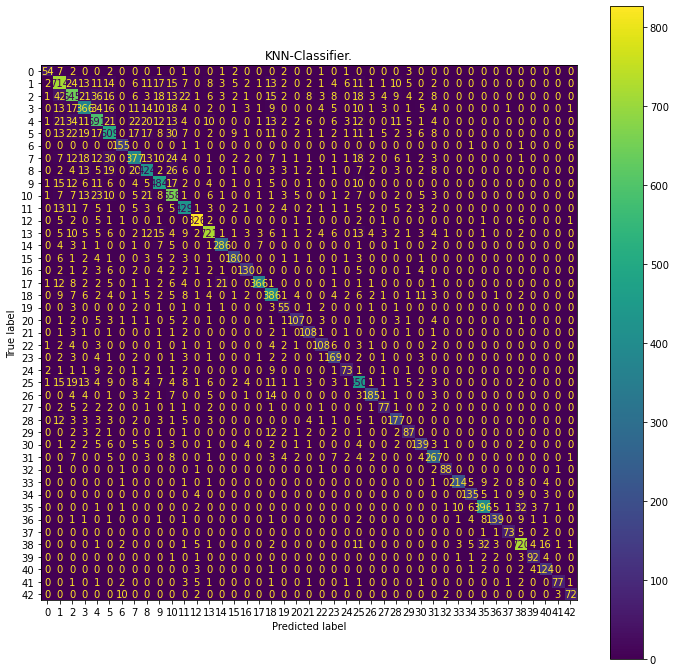

In [89]:
plot_final_confusion_matrix(best_models_acc['KNeighborsClassifier'])
plt.show()

## Results optimized for `f1_macro`

In [85]:
print_final_table(best_models_f1, scores_f1)

| Model | Default Accuracy | Default F1 | Accuracy | F1 | Accuracy Increase | F1 Increase |
| --- | --- | --- | ---| --- | --- | --- |
| GaussianNB | 0.1388888888888889 | 0.11677077813154453 | 0.1388888888888889 | 0.11677077813154453 | 0.0 | 0.0 |
| KNeighborsClassifier | 0.7307098765432098 | 0.7393902782290099 | 0.7994470164609053 | 0.8062181337924049 | 0.06873713991769548 | 0.06682785556339499 |
| LogisticRegression | 0.20588991769547324 | 0.07285031909797524 | 0.2550154320987654 | 0.15095963064699103 | 0.049125514403292186 | 0.07810931154901579 |
| MLPClassifier | 0.39338991769547327 | 0.36499312418653185 | 0.40419238683127573 | 0.3748055678575808 | 0.010802469135802462 | 0.009812443671048943 |
| SVC | 0.458397633744856 | 0.41620085087154907 | 0.5101594650205762 | 0.5844156227365354 | 0.051761831275720205 | 0.1682147718649863 |


(Same as for accuracy, because we got the same params for both accuracy and f1)

| Model | Default Accuracy | Default F1 | Accuracy | F1 | Accuracy Increase | F1 Increase |
| --- | --- | --- | ---| --- | --- | --- |
| GaussianNB | 0.1388888888888889 | 0.11677077813154453 | 0.1388888888888889 | 0.11677077813154453 | 0.0 | 0.0 |
| KNeighborsClassifier | 0.7307098765432098 | 0.7393902782290099 | 0.7994470164609053 | 0.8062181337924049 | 0.06873713991769548 | 0.06682785556339499 |
| LogisticRegression | 0.20588991769547324 | 0.07285031909797524 | 0.2550154320987654 | 0.15095963064699103 | 0.049125514403292186 | 0.07810931154901579 |
| MLPClassifier | 0.39338991769547327 | 0.36499312418653185 | 0.40419238683127573 | 0.3748055678575808 | 0.010802469135802462 | 0.009812443671048943 |
| SVC | 0.458397633744856 | 0.41620085087154907 | 0.5101594650205762 | 0.5844156227365354 | 0.051761831275720205 | 0.1682147718649863 |

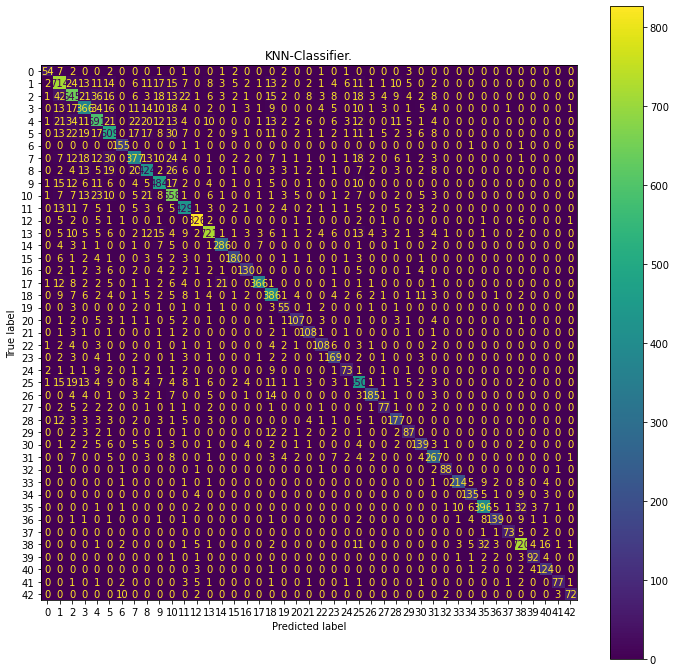

In [90]:
plot_final_confusion_matrix(best_models_f1['KNeighborsClassifier'])
plt.show()

## Remarks

As we can see the performance of KNN is unmatched. This is because KNN is very robust against imbalanced data.